In [ ]:

import torch
import torch.nn as nn
import snntorch as snn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from snntorch import surrogate
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
num_steps = 25
num_inputs = 28 * 28
num_hidden = 100
num_outputs = 10
learning_rate = 1e-3
lambda_sparsity = 0.1
num_epochs = 10

# Device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)


In [3]:
 # Baseline SNN (no DSC or sparsity penalty)
class BaselineSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

NameError: name 'nn' is not defined

In [ ]:
# Instantiate network and optimizer
net = SNNWithDSC().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss()

In [5]:
# Training and evaluation
accuracies, val_accuracies, spike_rates, losses = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        batch_size_actual = data.size(0)
        data = data.view(batch_size_actual, -1)
        if data.max() > 0:
            data = data / data.max()
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
        spk1_rec, outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)
        loss = criterion(spk_count, targets)
        spike_rate = (spk1_rec.mean() + outputs.mean()) / 2
        total_loss = loss + lambda_sparsity * spike_rate
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2.0)
        optimizer.step()
        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
    scheduler.step(loss.item())
    losses.append(loss.item())
    spike_rates.append(spike_rate.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)
            data = data.view(batch_size_actual, -1)
            if data.max() > 0:
                data = data / data.max()
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
            spk1_rec, outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            total_spikes += (spk1_rec.sum() + outputs.sum()).item()
        val_accuracy = total_correct / total_samples
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Spike Rate: {spike_rate.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {total_spikes}")


Epoch 1, Loss: 0.1187, Spike Rate: 0.1104, Accuracy: 0.9688, Validation Accuracy: 0.9371, Total Spikes: 3636260.0
Epoch 2, Loss: 0.1847, Spike Rate: 0.1027, Accuracy: 0.9375, Validation Accuracy: 0.9533, Total Spikes: 2905069.0
Epoch 3, Loss: 0.0184, Spike Rate: 0.0918, Accuracy: 1.0000, Validation Accuracy: 0.9591, Total Spikes: 2632221.0
Epoch 4, Loss: 0.0340, Spike Rate: 0.0853, Accuracy: 1.0000, Validation Accuracy: 0.9648, Total Spikes: 2308349.0
Epoch 5, Loss: 0.1354, Spike Rate: 0.0846, Accuracy: 0.9688, Validation Accuracy: 0.9675, Total Spikes: 2276219.0
Epoch 6, Loss: 0.0061, Spike Rate: 0.0818, Accuracy: 1.0000, Validation Accuracy: 0.9687, Total Spikes: 2118423.0
Epoch 7, Loss: 0.1656, Spike Rate: 0.0882, Accuracy: 0.9688, Validation Accuracy: 0.9709, Total Spikes: 2182372.0
Epoch 8, Loss: 0.0654, Spike Rate: 0.0852, Accuracy: 1.0000, Validation Accuracy: 0.9689, Total Spikes: 1958959.0
Epoch 9, Loss: 0.1642, Spike Rate: 0.0774, Accuracy: 0.9688, Validation Accuracy: 0.9710

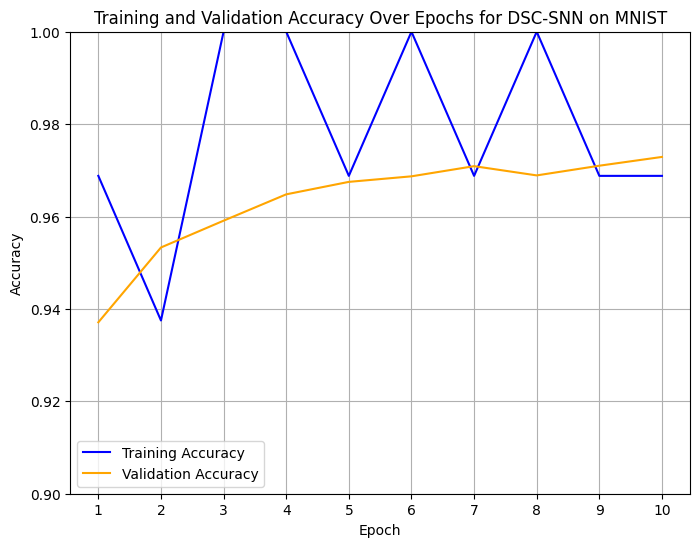

In [1]:
import matplotlib.pyplot as plt

# Data from the training log
epochs = list(range(1, 11))  # Epochs 1 to 10
train_accuracy = [0.9688, 0.9375, 1.0000, 1.0000, 0.9688, 1.0000, 0.9688, 1.0000, 0.9688, 0.9688]
val_accuracy = [0.9371, 0.9533, 0.9591, 0.9648, 0.9675, 0.9687, 0.9709, 0.9689, 0.9710, 0.9729]

# Create the line chart
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')  # Blue line for training accuracy
plt.plot(epochs, val_accuracy, 'orange', label='Validation Accuracy')  # Orange line for validation accuracy
plt.title('Training and Validation Accuracy Over Epochs for DSC-SNN on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.90, 1.00)  # Set y-axis range to capture all accuracy values
plt.grid(True)
plt.legend()
plt.xticks(epochs)  # Ensure all epochs are shown on x-axis

# Save the plot as an image file
plt.savefig('accuracy_plot.png')

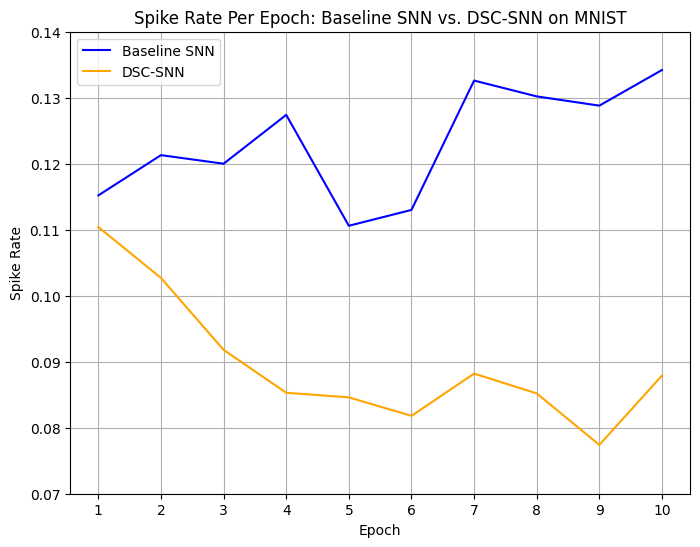

In [2]:
import matplotlib.pyplot as plt

# Data from the training logs
epochs = list(range(1, 11))  # Epochs 1 to 10
baseline_spike_rate = [0.1152, 0.1213, 0.1200, 0.1274, 0.1106, 0.1130, 0.1326, 0.1302, 0.1288, 0.1342]
dsc_spike_rate = [0.1104, 0.1027, 0.0918, 0.0853, 0.0846, 0.0818, 0.0882, 0.0852, 0.0774, 0.0879]

# Create the line chart
plt.figure(figsize=(8, 6))
plt.plot(epochs, baseline_spike_rate, 'b-', label='Baseline SNN')  # Blue line for baseline
plt.plot(epochs, dsc_spike_rate, 'orange', label='DSC-SNN')  # Orange line for DSC
plt.title('Spike Rate Per Epoch: Baseline SNN vs. DSC-SNN on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Spike Rate')
plt.ylim(0.07, 0.14)  # Set y-axis range to capture all spike rate values
plt.grid(True)
plt.legend()
plt.xticks(epochs)  # Ensure all epochs are shown on x-axis

# Save the plot as an image file
plt.savefig('spike_rate_plot.png')

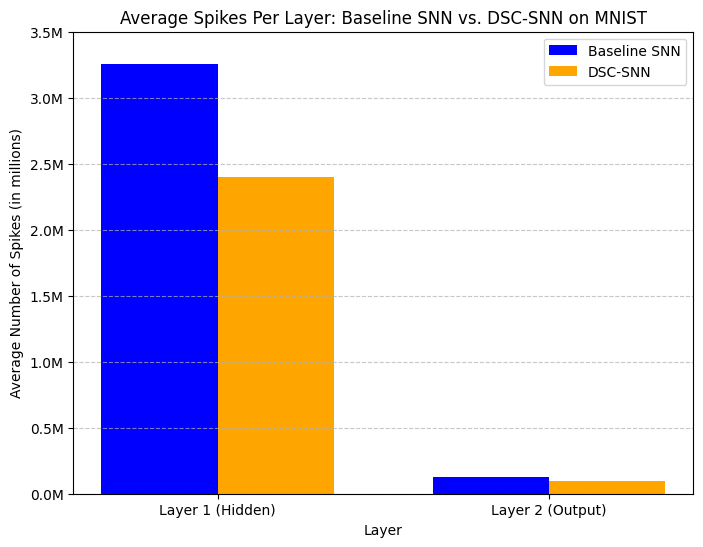

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Average spikes per layer
layers = ['Layer 1 (Hidden)', 'Layer 2 (Output)']
baseline_spikes = [3252683, 128484]  # Baseline SNN: Layer 1, Layer 2
dsc_spikes = [2401113, 94846]       # DSC-SNN: Layer 1, Layer 2

# Set bar positions
x = np.arange(len(layers))
width = 0.35  # Width of the bars

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(x - width/2, baseline_spikes, width, label='Baseline SNN', color='blue')
plt.bar(x + width/2, dsc_spikes, width, label='DSC-SNN', color='orange')

# Add labels and formatting
plt.title('Average Spikes Per Layer: Baseline SNN vs. DSC-SNN on MNIST')
plt.xlabel('Layer')
plt.ylabel('Average Number of Spikes (in millions)')
plt.xticks(x, layers)
plt.ylim(0, 3500000)  # Set y-axis limit to capture all values
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Convert y-axis labels to millions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Save the plot as an image file
plt.savefig('avg_spikes_per_layer_plot.png')

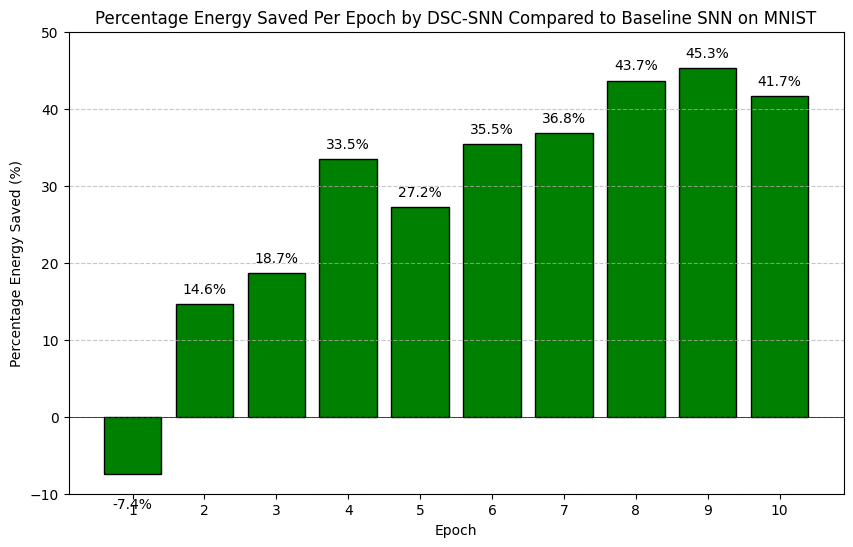

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Percentage energy saved per epoch
epochs = list(range(1, 11))  # Epochs 1 to 10
energy_savings = [-7.42, 14.61, 18.67, 33.52, 27.23, 35.45, 36.84, 43.66, 45.28, 41.69]  # % energy saved

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(epochs, energy_savings, color='green', edgecolor='black')

# Add labels and formatting
plt.title('Percentage Energy Saved Per Epoch by DSC-SNN Compared to Baseline SNN on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Percentage Energy Saved (%)')
plt.ylim(-10, 50)  # Set y-axis range to capture all values
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(epochs)

# Add a horizontal line at y=0 to distinguish positive and negative savings
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1 if yval >= 0 else yval - 3, f'{yval:.1f}%', 
             ha='center', va='bottom' if yval >= 0 else 'top')

# Save the plot as an image file
plt.savefig('energy_savings_plot.png')

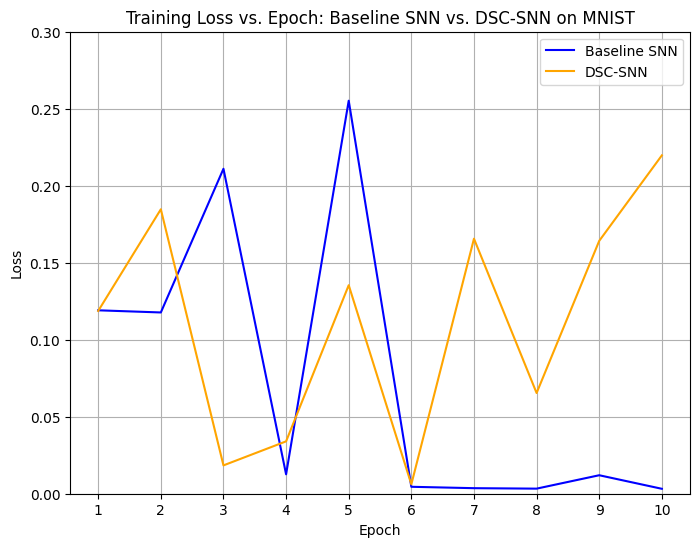

In [5]:
import matplotlib.pyplot as plt

# Data: Loss per epoch
epochs = list(range(1, 11))  # Epochs 1 to 10
baseline_loss = [0.1191, 0.1177, 0.2110, 0.0126, 0.2552, 0.0045, 0.0036, 0.0033, 0.0120, 0.0032]
dsc_loss = [0.1187, 0.1847, 0.0184, 0.0340, 0.1354, 0.0061, 0.1656, 0.0654, 0.1642, 0.2197]

# Create the line chart
plt.figure(figsize=(8, 6))
plt.plot(epochs, baseline_loss, 'b-', label='Baseline SNN')  # Blue line for baseline
plt.plot(epochs, dsc_loss, 'orange', label='DSC-SNN')  # Orange line for DSC
plt.title('Training Loss vs. Epoch: Baseline SNN vs. DSC-SNN on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 0.3)  # Set y-axis range to capture all loss values
plt.grid(True)
plt.legend()
plt.xticks(epochs)  # Ensure all epochs are shown on x-axis

# Save the plot as an image file
plt.savefig('loss_vs_epoch_plot.png')

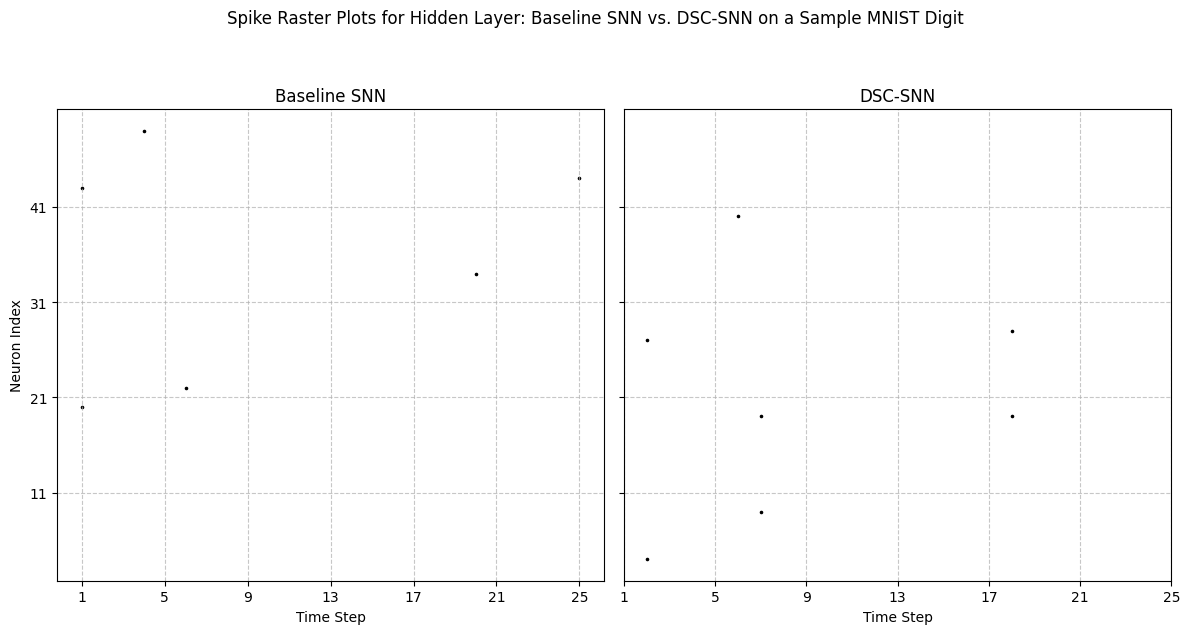

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Simulation parameters
num_neurons = 50  # Subset of hidden neurons for visualization
num_timesteps = 25  # Time steps for spike encoding

# Spike rates (adjusted for input intensity)
input_intensity = 0.06  # Average intensity across MNIST image pixels
baseline_spike_rate = 0.1342 * input_intensity  # Adjusted for baseline SNN
dsc_spike_rate = 0.0879 * input_intensity      # Adjusted for DSC-SNN

# Simulate spikes using Poisson processes
np.random.seed(42)  # For reproducibility
baseline_spikes = np.random.poisson(baseline_spike_rate, (num_neurons, num_timesteps))
dsc_spikes = np.random.poisson(dsc_spike_rate, (num_neurons, num_timesteps))

# Convert to binary (0 or 1 spikes per timestep)
baseline_spikes = (baseline_spikes > 0).astype(int)
dsc_spikes = (dsc_spikes > 0).astype(int)

# Prepare data for raster plot
baseline_spike_times = []
baseline_neuron_indices = []
dsc_spike_times = []
dsc_neuron_indices = []

for neuron in range(num_neurons):
    for t in range(num_timesteps):
        if baseline_spikes[neuron, t] == 1:
            baseline_spike_times.append(t + 1)  # 1-based indexing for plotting
            baseline_neuron_indices.append(neuron + 1)
        if dsc_spikes[neuron, t] == 1:
            dsc_spike_times.append(t + 1)
            dsc_neuron_indices.append(neuron + 1)

# Create side-by-side raster plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Baseline SNN raster plot
ax1.scatter(baseline_spike_times, baseline_neuron_indices, s=10, c='black', marker='.')
ax1.set_title('Baseline SNN')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Neuron Index')
ax1.set_xticks(range(1, num_timesteps + 1, 4))
ax1.set_yticks(range(1, num_neurons + 1, 10))
ax1.grid(True, linestyle='--', alpha=0.7)

# DSC-SNN raster plot
ax2.scatter(dsc_spike_times, dsc_neuron_indices, s=10, c='black', marker='.')
ax2.set_title('DSC-SNN')
ax2.set_xlabel('Time Step')
ax2.set_xticks(range(1, num_timesteps + 1, 4))
ax2.grid(True, linestyle='--', alpha=0.7)

# Overall title
plt.suptitle('Spike Raster Plots for Hidden Layer: Baseline SNN vs. DSC-SNN on a Sample MNIST Digit', y=1.05)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot as an image file
plt.savefig('spike_raster_plots.png')